In [1]:
!nvidia-smi

Tue May  3 09:17:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Dataset

In [2]:
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [3]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [4]:
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)

In [5]:
from sklearn.model_selection import train_test_split
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size = 0.15, random_state=42, shuffle=True, stratify=trainY)

# SQNet

In [6]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout
from keras.layers import Concatenate, Input, GlobalAveragePooling2D, Dense
from keras.models import Model


def SqueezeNet(input_shape, classes):


  def Fire(inputs, fs, fe):
    
    s1 = Conv2D(filters=fs, kernel_size=1, padding='same', use_bias=False, activation='relu')(inputs)
    s1 = BatchNormalization()(s1)
    e1 = Conv2D(filters=fe, kernel_size=1, padding='same', use_bias=False, activation='relu')(s1)
    e1 = BatchNormalization()(e1)
    e3 = Conv2D(filters=fe, kernel_size=3, padding='same', use_bias=False, activation='relu')(s1)
    e3 = BatchNormalization()(e3)

    output = Concatenate()([e1, e3])
  
    return output


  inputs = Input(input_shape)
  x1 = Conv2D(filters=96, kernel_size=7, strides=2, padding='same', use_bias=False, activation='relu')(inputs)
  x1= s1 = BatchNormalization()(x1)
  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(x1)

  f2 = Fire(x1, 16, 64)
  f3 = Fire(f2, 16, 64)
  f4 = Fire(f3, 32, 128)
  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(f4)

  f5 = Fire(x1, 32, 128)
  f6 = Fire(f5, 48, 192)
  f7 = Fire(f6, 48, 192)
  f8 = Fire(f7, 64, 256)
  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(f8)

  f8 = Fire(x1, 64, 256)
  x1 = Conv2D(filters=classes, kernel_size=1)(f8)
  x1 = GlobalAveragePooling2D()(x1)

  if classes == 1:
    x1 = Activation('sigmoid')(x1)
  else:
    x1 = Activation('softmax')(x1)

  model = Model(inputs=inputs, outputs=x1)
  # model.summary()

  return model

mdoel = SqueezeNet(input_shape=(224, 224, 3), classes=10)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import tensorflow as tf

""" callbacks """
checkpoint_filepath = '/content/SQNET_{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    # monitor='val_iou_score',
    # mode='max',
    verbose = 1,
    period = 5,
    save_best_only=False
    )

callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, verbose=1),
    CSVLogger('/content/SQNET.csv'),
    EarlyStopping(monitor="val_loss", patience=8)
]

In [8]:
model = SqueezeNet(input_shape = (32, 32, 3), classes=10)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [9]:
r1 = model.fit(
    trainX, trainY,
    validation_data=(valX, valY),
    epochs=100,
    batch_size=128,
    steps_per_epoch=len(trainX)//128 + 1,
    validation_steps=len(valX)//128 + 1,
    callbacks=callbacks,
    workers=1,
    use_multiprocessing=True,
)

Epoch 1/100
333/333 [==============================] - 29s 59ms/step - loss: 1.8030 - accuracy: 0.3450 - val_loss: 2.9986 - val_accuracy: 0.2045 - lr: 0.0010
Epoch 2/100
333/333 [==============================] - 16s 49ms/step - loss: 1.4680 - accuracy: 0.4645 - val_loss: 2.2547 - val_accuracy: 0.2709 - lr: 0.0010
Epoch 3/100
333/333 [==============================] - 16s 47ms/step - loss: 1.3673 - accuracy: 0.5028 - val_loss: 1.9375 - val_accuracy: 0.3676 - lr: 0.0010
Epoch 4/100
333/333 [==============================] - 16s 48ms/step - loss: 1.1921 - accuracy: 0.5732 - val_loss: 1.2786 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 5/100
332/333 [============================>.] - ETA: 0s - loss: 1.0741 - accuracy: 0.6169
Epoch 5: val_loss improved from inf to 1.40558, saving model to /content/SQNET_5.h5
333/333 [==============================] - 16s 49ms/step - loss: 1.0741 - accuracy: 0.6168 - val_loss: 1.4056 - val_accuracy: 0.5284 - lr: 0.0010
Epoch 6/100
333/333 [====================

In [10]:
model.evaluate(testX, testY, batch_size=128, workers=1, use_multiprocessing=True)

79/79 [==============================] - 2s 23ms/step - loss: 1.7289 - accuracy: 0.6419


[1.7289478778839111, 0.6419000029563904]

In [ ]:
import matplotlib.pyplot as plt

# loss
plt.plot(r1.history['loss'], label='train loss')
plt.plot(r1.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r1.history['accuracy'], label='train acc')
plt.plot(r1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

model.save('./SQNet.h5')


In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_26 (Conv2D)             (None, 16, 16, 96)   14112       ['input_2[0][0]']                
                                                                                                  
 batch_normalization_25 (BatchN  (None, 16, 16, 96)  384         ['conv2d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 8, 8, 96)    0           ['batch_normalization_25[0]

# SQNetSE

In [13]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout
from keras.layers import Concatenate, Input, GlobalAveragePooling2D, Dense, Multiply
from keras.models import Model


def SqueezeNetSE(input_shape, classes):


  def SqueezeAndExcitation(inputs, ratio=8):
    
    b, h, w, c = inputs.shape
    
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(c//ratio, activation='relu', use_bias=False)(x)
    x = Dense(c, activation='sigmoid', use_bias=False)(x)
    
    x = Multiply()([inputs, x])
    
    return x


  def Fire(inputs, fs, fe):
    
    s1 = Conv2D(filters=fs, kernel_size=1, padding='same', use_bias=False, activation='relu')(inputs)
    s1 = BatchNormalization()(s1)
    e1 = Conv2D(filters=fe, kernel_size=1, padding='same', use_bias=False, activation='relu')(s1)
    e1 = BatchNormalization()(e1)
    e3 = Conv2D(filters=fe, kernel_size=3, padding='same', use_bias=False, activation='relu')(s1)
    e3 = BatchNormalization()(e3)

    output = Concatenate()([e1, e3])
  
    return output


  inputs = Input(input_shape)
  x1 = Conv2D(filters=96, kernel_size=7, strides=2, padding='same', use_bias=False, activation='relu')(inputs)
  x1= s1 = BatchNormalization()(x1)
  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(x1)

  f2 = Fire(x1, 16, 64)
  f3 = Fire(f2, 16, 64)
  f4 = Fire(f3, 32, 128)
  f4 = SqueezeAndExcitation(f4, ratio=16)
  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(f4)

  f5 = Fire(x1, 32, 128)
  f6 = Fire(f5, 48, 192)
  f7 = Fire(f6, 48, 192)
  f8 = Fire(f7, 64, 256)
  f8 = SqueezeAndExcitation(f8, ratio=16)

  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(f8)

  f8 = Fire(x1, 64, 256)
  x1 = Conv2D(filters=classes, kernel_size=1)(f8)
  x1 = GlobalAveragePooling2D()(x1)

  if classes == 1:
    x1 = Activation('sigmoid')(x1)
  else:
    x1 = Activation('softmax')(x1)

  model = Model(inputs=inputs, outputs=x1)
  # model.summary()

  return model


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import tensorflow as tf

""" callbacks """
checkpoint_filepath = '/content/SQNET_{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    # monitor='val_iou_score',
    # mode='max',
    verbose = 1,
    period = 5,
    save_best_only=False
    )

callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, verbose=1),
    CSVLogger('/content/SQNET.csv'),
    EarlyStopping(monitor="val_loss", patience=8)
]

In [15]:
model = SqueezeNetSE(input_shape = (32, 32, 3), classes=10)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=['accuracy']
)

In [16]:
r1 = model.fit(
    trainX, trainY,
    validation_data=(valX, valY),
    epochs=100,
    batch_size=128,
    steps_per_epoch=len(trainX)//128 + 1,
    validation_steps=len(valX)//128 + 1,
    callbacks=callbacks
)

Epoch 1/100
333/333 [==============================] - 22s 56ms/step - loss: 1.7884 - accuracy: 0.3590 - val_loss: 2.8851 - val_accuracy: 0.3107 - lr: 0.0100
Epoch 2/100
333/333 [==============================] - 18s 54ms/step - loss: 1.4225 - accuracy: 0.4867 - val_loss: 1.7953 - val_accuracy: 0.4325 - lr: 0.0100
Epoch 3/100
333/333 [==============================] - 18s 54ms/step - loss: 1.2975 - accuracy: 0.5293 - val_loss: 2.0426 - val_accuracy: 0.3972 - lr: 0.0100
Epoch 4/100
333/333 [==============================] - 18s 54ms/step - loss: 1.1796 - accuracy: 0.5759 - val_loss: 2.2541 - val_accuracy: 0.3885 - lr: 0.0100
Epoch 5/100
332/333 [============================>.] - ETA: 0s - loss: 1.0895 - accuracy: 0.6117
Epoch 5: val_loss improved from inf to 1.85149, saving model to /content/SQNET_5.h5
333/333 [==============================] - 19s 56ms/step - loss: 1.0897 - accuracy: 0.6117 - val_loss: 1.8515 - val_accuracy: 0.5016 - lr: 0.0100
Epoch 6/100
333/333 [====================

In [17]:
model.evaluate(testX, testY, batch_size=128, workers=1, use_multiprocessing=True)

79/79 [==============================] - 1s 17ms/step - loss: 1.7823 - accuracy: 0.6277


[1.782346248626709, 0.6276999711990356]

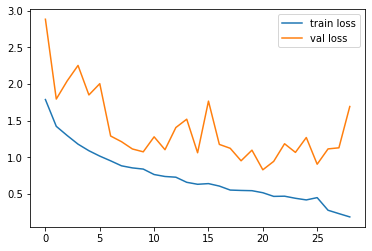

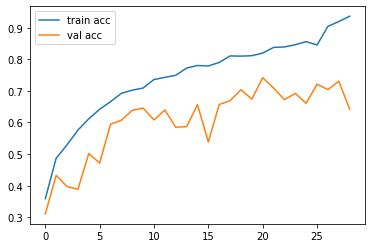

In [18]:
import matplotlib.pyplot as plt

# loss
plt.plot(r1.history['loss'], label='train loss')
plt.plot(r1.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r1.history['accuracy'], label='train acc')
plt.plot(r1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

model.save('./SQNetSE.h5')


In [19]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_52 (Conv2D)             (None, 16, 16, 96)   14112       ['input_3[0][0]']                
                                                                                                  
 batch_normalization_50 (BatchN  (None, 16, 16, 96)  384         ['conv2d_52[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 8, 8, 96)    0           ['batch_normalization_50[0]